In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob

np.random.seed(19940904)

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Model

In [3]:
import keras
from keras import layers

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### AutoEncoder and Encoder

In [4]:
height = 64
width = 64
channels = 3

input_layer = layers.Input(name='input', shape=(height, width, channels))

# Encoder
x = layers.Conv2D(32, (5,5), strides=(1,1), padding='same', name='conv_1', kernel_regularizer = 'l2')(input_layer)
x = layers.LeakyReLU(name='leaky_1')(x)

x = layers.Conv2D(64, (3,3), strides=(2,2), padding='same', name='conv_2', kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(name='norm_1')(x)
x = layers.LeakyReLU(name='leaky_2')(x)


x = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='conv_3', kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(name='norm_2')(x)
x = layers.LeakyReLU(name='leaky_3')(x)


x = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='conv_4', kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(name='norm_3')(x)
x = layers.LeakyReLU(name='leaky_4')(x)

x = layers.Flatten(name='g_encoder_output')(x)


# Decoder
y = layers.Reshape((8, 8, 128), name='de_reshape')(x)

y = layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', name='deconv_1', kernel_regularizer = 'l2')(y)
y = layers.LeakyReLU(name='de_leaky_1')(y)

y = layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', name='deconv_2', kernel_regularizer = 'l2')(y)
y = layers.LeakyReLU(name='de_leaky_2')(y)

y = layers.Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', name='deconv_3', kernel_regularizer = 'l2')(y)
y = layers.LeakyReLU(name='de_leaky_3')(y)

y = layers.Conv2DTranspose(channels, (1, 1), strides=(1,1), padding='same', name='decoder_deconv_output', kernel_regularizer = 'l2', activation='tanh')(y)

# #encoder
z = layers.Conv2D(32, (5,5), strides=(1,1), padding='same', name='encoder_conv_1', kernel_regularizer = 'l2')(y)
z = layers.LeakyReLU()(z)

z = layers.Conv2D(64, (3,3), strides=(2,2), padding='same', name='encoder_conv_2', kernel_regularizer = 'l2')(z)
z = layers.BatchNormalization(name='encoder_norm_1')(z)
z = layers.LeakyReLU()(z)


z = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='encoder_conv_3', kernel_regularizer = 'l2')(z)
z = layers.BatchNormalization(name='encoder_norm_2')(z)
z = layers.LeakyReLU()(z)


z = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='conv_41', kernel_regularizer = 'l2')(z)
z = layers.BatchNormalization(name='encoder_norm_3')(z)
z = layers.LeakyReLU()(z)

z = layers.Flatten(name='encoder_output')(z)


# feature extractor
f = layers.Conv2D(32, (5,5), strides=(1,1), padding='same', name='f_conv_1', kernel_regularizer = 'l2')(y)
f = layers.LeakyReLU(name='f_leaky_1')(f)

f = layers.Conv2D(64, (3,3), strides=(2,2), padding='same', name='f_conv_2', kernel_regularizer = 'l2')(f)
f = layers.BatchNormalization(name='f_norm_1')(f)
f = layers.LeakyReLU(name='f_leaky_2')(f)


f = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='f_conv_3', kernel_regularizer = 'l2')(f)
f = layers.BatchNormalization(name='f_norm_2')(f)
f = layers.LeakyReLU(name='f_leaky_3')(f)


f = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='f_conv_4', kernel_regularizer = 'l2')(f)
f = layers.BatchNormalization(name='f_norm_3')(f)
f = layers.LeakyReLU(name='feature_output')(f)

autoencoder = keras.models.Model(inputs=input_layer, outputs=[y, z, f])

print(autoencoder.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 64, 64, 32)   2432        input[0][0]                      
__________________________________________________________________________________________________
leaky_1 (LeakyReLU)             (None, 64, 64, 32)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 32, 32, 64)   18496       leaky_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (Ba

## encoder

In [5]:
encoder = keras.models.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('g_encoder_output').output)
print(encoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 64, 64, 3)         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 64, 64, 32)        2432      
_________________________________________________________________
leaky_1 (LeakyReLU)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 32, 64)        18496     
_________________________________________________________________
norm_1 (BatchNormalization)  (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_2 (LeakyReLU)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 16, 16, 128)       73856     
__________

### Feature Extractor

In [6]:
decoded_input = layers.Input(name='input', shape=(height, width, channels))

f = autoencoder.get_layer('f_conv_1')(decoded_input)
f = autoencoder.get_layer('f_leaky_1')(f)

f = autoencoder.get_layer('f_conv_2')(f)
f = autoencoder.get_layer('f_norm_1')(f)
f = autoencoder.get_layer('f_leaky_2')(f)

f = autoencoder.get_layer('f_conv_3')(f)
f = autoencoder.get_layer('f_norm_2')(f)
f = autoencoder.get_layer('f_leaky_3')(f)

f = autoencoder.get_layer('f_conv_4')(f)
f = autoencoder.get_layer('f_norm_3')(f)
f = autoencoder.get_layer('feature_output')(f)
    
feature_extractor = keras.models.Model(decoded_input, f)
print(feature_extractor.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 64, 64, 3)         0         
_________________________________________________________________
f_conv_1 (Conv2D)            (None, 64, 64, 32)        2432      
_________________________________________________________________
f_leaky_1 (LeakyReLU)        (None, 64, 64, 32)        0         
_________________________________________________________________
f_conv_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
f_norm_1 (BatchNormalization (None, 32, 32, 64)        256       
_________________________________________________________________
f_leaky_2 (LeakyReLU)        (None, 32, 32, 64)        0         
_________________________________________________________________
f_conv_3 (Conv2D)            (None, 16, 16, 128)       73856     
__________

### EncodeDecoder

In [7]:
encoddecoderencoder = keras.models.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder_output').output)

### Loss and Compile

In [8]:
losses = {
    'decoder_deconv_output': keras.losses.mean_absolute_error,
    'encoder_output': keras.losses.mean_squared_error,
    'feature_output': keras.losses.mean_squared_error,
}
lossWeights = {'decoder_deconv_output': 5.0, 'encoder_output': 1.0, 'feature_output': 1.0}
autoencoder.compile(optimizer = "adam", loss=losses, loss_weights=lossWeights)

# read data

In [9]:
# files = glob.glob('/home/jovyan/anomaly_detection/data/*/0/*.png')
# np.random.shuffle(files)

In [10]:
# trina_files = files[:10000]

In [11]:
# val_files = files[10000:10100]

In [12]:
# trina_data = np.empty((len(trina_files), 64, 64, 3))
# skip = 0
# for i, p in enumerate(trina_files):
#     img = cv2.imread(p)
#     if img.shape != (50, 50, 3):
#         skip += 1
#         continue
#     trina_data[i-skip] = cv2.resize(img, (64, 64))[:, :, ::-1] / 127 - 1
# if skip > 0:
#     trina_data = trina_data[:-skip]

In [13]:
# val_data = np.empty((len(val_files), 64, 64, 3))
# skip = 0
# for i, p in enumerate(val_files):
#     img = cv2.imread(p)
#     if img.shape != (50, 50, 3):
#         skip += 1
#         continue
#     val_data[i-skip] = cv2.resize(img, (64, 64))[:, :, ::-1] / 127 - 1
# if skip > 0:
#     val_data = val_data[:-skip]

In [14]:
# print(len(trina_data))
# print(len(val_data))

In [15]:
nepoch = 100
batch_size = 32

In [41]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_ok = x_train[y_train == 1]
# x_test = x_test[(y_test == 7) | (y_test == 1)]
# y_test = y_test[(y_test == 7) | (y_test == 1)]

In [43]:
def reshape_x(x, size):
    new_x = np.empty((len(x), size, size))

    for i, e in enumerate(x):
        cv2.resize(e, (size, size))
        new_x[i] = cv2.resize(e, (size, size))
        
        
    new_x = np.expand_dims(new_x, axis=-1)
    new_x = np.repeat(new_x, 3, axis=-1)
    return (new_x / 127) - 1

In [44]:
x_ok = reshape_x(x_ok, 64)
x_test = reshape_x(x_test, 64)

In [45]:
np.random.shuffle(x_ok)
train_x = x_ok[:int(6742*0.8)]
val_x = x_ok[int(6742*0.8):]
print(len(x_ok), len(train_x), len(val_x))

6742 5393 1349


In [46]:
print(x_ok.max(), x_ok.min())

1.0078740157480315 -1.0


In [21]:
def data_generator(data, batch_size=32):
    datalen = len(data)
    cnt = 0
    while True:
        idxes = np.arange(datalen)
        np.random.shuffle(idxes)
        cnt += 1
        for i in range(int(np.ceil(datalen/batch_size))):
            train_x = np.take(data, idxes[i*batch_size: (i+1) * batch_size], axis=0)
            train_y = {
                'decoder_deconv_output': train_x,
                'encoder_output': encoder.predict(train_x),
                'feature_output': feature_extractor.predict(train_x),
            }
            yield train_x, train_y


In [22]:
encoder.predict(x_ok[:1]).shape

(1, 8192)

In [23]:
feature_extractor.predict(x_ok[:1]).shape

(1, 8, 8, 128)

# train

In [24]:
autoencoder.fit_generator(data_generator(train_x), 
                          steps_per_epoch=len(train_x)//32,
                          epochs=100,
                          callbacks=None, 
                          validation_data=data_generator(val_x),
                          validation_steps=len(val_x)//32,
                         )

Epoch 1/100
168/168 [==============================] - 10s 57ms/step - loss: 5.8747 - decoder_deconv_output_loss: 0.0768 - encoder_output_loss: 0.1871 - feature_output_loss: 2.5531 - val_loss: 4.3139 - val_decoder_deconv_output_loss: 0.6744 - val_encoder_output_loss: 0.0552 - val_feature_output_loss: 0.3342
Epoch 2/100
168/168 [==============================] - 7s 40ms/step - loss: 0.6547 - decoder_deconv_output_loss: 0.0204 - encoder_output_loss: 0.0624 - feature_output_loss: 0.1316 - val_loss: 2.7427 - val_decoder_deconv_output_loss: 0.3645 - val_encoder_output_loss: 0.6343 - val_feature_output_loss: 0.0172
Epoch 3/100
168/168 [==============================] - 7s 40ms/step - loss: 1.1237 - decoder_deconv_output_loss: 0.0193 - encoder_output_loss: 0.0327 - feature_output_loss: 0.7650 - val_loss: 140.9075 - val_decoder_deconv_output_loss: 0.0852 - val_encoder_output_loss: 0.1241 - val_feature_output_loss: 140.0525
Epoch 4/100
168/168 [==============================] - 7s 40ms/step - l

# train batch result

In [25]:
i = 4

In [ ]:
img = train_x[1] * 127 + 127
plt.imshow(img.astype(np.uint8))

In [28]:
autoencoder.save('model/ganormaly_autoencoder.h5')

# Compute Score

In [47]:
encoded = encoder.predict(x_test)

In [48]:
encoded_gan = encoddecoderencoder.predict(x_test)

In [49]:
import keras.backend as K

In [50]:
score = np.sum(np.absolute(encoded, encoded_gan), axis=-1)

In [51]:
score = (score - np.min(score)) / (np.max(score) - np.min(score))

In [52]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

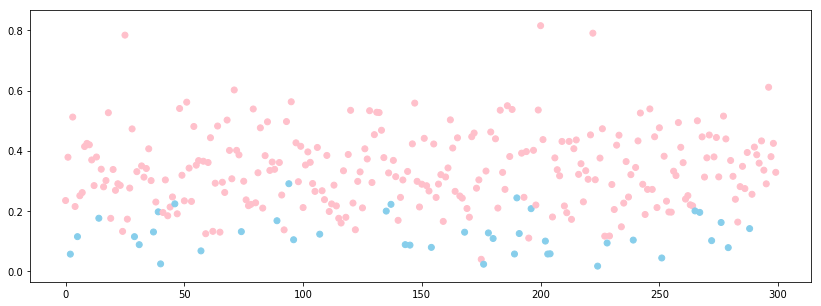

In [53]:
plt.scatter(range(len(x_test[:300])), score[:300], c=['skyblue' if x == 1 else 'pink' for x in y_test[:300]])

In [59]:
print('normal accuracy: %.2f' % (len(score[(y_test == 1) & (score < 0.2)]) / 1135))
print('abnormal accuracy: %.2f' % (len(score[(y_test != 1) & (score > 0.2)]) / len(score[y_test != 1])))

normal accuracy: 0.79
abnormal accuracy: 0.93
